In [1]:
import sys, getopt, re

def main(argv):
    inputfile = ''
    try:
        opts, args = getopt.getopt(argv,"i:")
        # print(opts,args)
    except getopt.GetoptError:
        print('LanguageModeling.py -i <BRAND>')
        sys.exit(2)
    
    for opt, arg in opts:
        if opt == "-i":
            inputfile = arg
    
    if len(inputfile)==0:
        print('usage: LanguageModeling.py -i <BRAND>')
        sys.exit(2)
    print('Input BRAND is ', inputfile)
    return inputfile

In [2]:
BRAND      = 'HAIRCARE'

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

---

In [4]:
from fastai.text import * # Quick access to NLP functionality
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import linalg as LA

# Pre-Processing

## Data Loading (from saved verbatim)

In [6]:
df = pd.read_csv('./data/sample_data.csv', dtype={'verbatum':object})

df.head()

,snippet,product,rating,verbatum,sentiment_binary,sentiment,date,retailer,website,topic
0,This shampoo sprays crazy good and it has save...,Head And Shoulders Smooth & Silky Dandruff Sha...,5.0,This shampoo sprays crazy good and it has save...,1,Positive,5/2/2018,-,https://www.walmart.com/ip/Head-and-Shoulders-...,Spray Application
1,The thing I always remember about Head & Shoul...,Head And Shoulders Green Apple Anti-Dandruff S...,5.0,My teenaged daughter has been using Head & Sho...,1,Positive,9/29/2017,AMZ,https://www.amazon.com/Head-Shoulders-Anti-Dan...,Spray Application
2,"My long, thick, wavy, hair is frequently abuse...",Dove Dermacare Scalp Anti-Dandruff Shampoo Inv...,4.0,"To my surprise, Dove DermaCare Scalp Invigorat...",1,Positive,1/27/2017,WALMART,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
3,"From their body sprays, to their deodorant, so...",Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...,5.0,I let my boyfriend try this product. He loves ...,1,Positive,1/27/2017,-,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
4,"Its conveniently packaged, but if this bottle ...","Head And Shoulders Dry Scalp Care, Almond Oil,...",4.0,"Its conveniently packaged, but if this bottle ...",1,Positive,1/14/2016,AMZ,https://www.amazon.com/Head-Shoulders-Almond-D...,Spray Application


## Data Cleaning

Extract the full verbatum; remove duplicates and too short verbatum 

In [7]:
# keep a copy of the rating
df_orig = df[['rating','product']].copy()

# get full verbatum and enforce
df = df[['verbatum']].rename(columns = {'verbatum':'text'})

# enforce format
df['text'] = df['text'].astype(str)

# remove short comments (keep 2nd percentile and higher lenghts)
thresh = df['text'].apply(len).quantile(0.02)

df = df.loc[df['text'].apply(lambda x: len(x)>=thresh)].\
    drop_duplicates()

In [8]:
df.head()

,text
0,This shampoo sprays crazy good and it has save...
1,My teenaged daughter has been using Head & Sho...
2,"To my surprise, Dove DermaCare Scalp Invigorat..."
3,I let my boyfriend try this product. He loves ...
4,"Its conveniently packaged, but if this bottle ..."


## Pre-Tokenization

In [9]:
# Setup stop words
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

for word in STOP_WORDS:
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True

In [12]:
# from nltk.corpus import stopwords
#import spacy
import string

# stop = set(stopwords.words('english'))
exclude = set(string.punctuation)#-set(['!','?'])

# nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

def preprocess(doc, tags=['NOUN', 'ADJ','VERB','ADV']):
    # make entire text lower case
    doc = doc.lower()    
    
    # replace "n't" with " not" & remove unwanted characters, numbers and symbols
    doc = doc.replace("n\'t", " not").replace("[^a-zA-Z#]", " ")
       
    # remove short words (length < 3)
    doc = " ".join([r for r in doc.split() if len(r)>2])
    
    # remove punctuation
    doc = ''.join(ch for ch in doc if ch not in exclude)
    
    # lemmatization
    doc = " ".join([token.lemma_ for token in nlp(doc) if ((token.pos_ in tags) and not(token.is_stop))])
    return doc

In [13]:
# removes stop words, short words, and punctuation; lowercase and lemmatize all
print(' Pre-Tokenization')
df['text']        = df['text'].apply(preprocess)

 Pre-Tokenization


## Text vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [15]:
# number of words to keep
no_features = 10000

In [47]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df['text'].values)
tf_feature_names = tf_vectorizer.get_feature_names()

In [17]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
no_topics      =  25
learning_decay = 0.7

# run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=10, learning_method='online', \
                                random_state=0)

lda.fit(tf)

lda.perplexity(tf)

In [36]:
def get_top_words(model, feature_names, no_top_words):
    topwords = []
    for topic_idx, topic in enumerate(model.components_):
        topwords.append(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return topwords

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
bottle shampoo good price product great come store size job
Topic 1:
scalp hair dry shampoo use dandruff help product good smell
Topic 2:
preventative reorder source cease yr measure dundruff granddaughter revamp havnt
Topic 3:
natural crazy drive pure rely gold wild intrigue seperate highend
Topic 4:
dandrift stage manner oder bone smoothe proud facebook timely proceed
Topic 5:
excite specific personal dog unique stringy resolve explain bag candy
Topic 6:
scent apple dove shampoo mint green old residue dermacare relief
Topic 7:
work smell great dandruff product buy bad clear try away
Topic 8:
stuff psoriasis save time dermatologist cheap different buy cut gel
Topic 9:
sample hair super cool kind exactly shine fade nicely curl
Topic 10:
remove daughter buildup dermatitis build seborrheic brush water touch disappear
Topic 11:
sensitive strong quickly prefer turn break effect avoid pleasant hesitant
Topic 12:
product free receive opinion review test smell love influenster dandru

In [39]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
24      30.397549 -139.465363       1        1  24.066593
19      78.194908  102.870209       2        1  20.604055
21     157.150299  -47.839680       3        1  12.873215
12      18.896210  137.505661       4        1  10.190143
1      -38.300720  180.286926       5        1   9.780327
7     -155.229706  -26.690439       6        1   4.151707
0       84.721298   39.263645       7        1   3.492010
6      147.233185  105.496132       8        1   3.124360
8       90.629532  -24.077160       9        1   1.754277
16      22.299994   67.470551      10        1   1.203045
17     -94.149315  -70.129150      11        1   1.136897
10     -30.155375   35.375092      12        1   1.072158
9     -108.201935  135.544235      13        1   1.009603
13      28.068392    3.786891      14        1   0.931133
11     154.601776   29.396738      15        1   0.899767
14      78.648590  176.923477      16        1   0.799440
15     -21.563271  -88.176285      17        1   0.523604
20     -66.746078 -140.844910      18        1   0.483583
23    -156.550385   56.609894      19        1   0.435149
3      -88.551720   65.916893      20        1   0.317881
5      -36.535217  103.368820      21        1   0.308794
18     -88.923653    0.088916      22        1   0.266963
22     -28.915007  -26.493647      23        1   0.197487
4       36.907047  -60.495762      24        1   0.189780
2       98.540718 -101.713875      25        1   0.188030, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1308  Default  8732.000000           hair  8732.000000  30.0000  30.0000
2219  Default  7252.000000        product  7252.000000  29.0000  29.0000
1348  Default  3215.000000           head  3215.000000  28.0000  28.0000
3267  Default  2459.000000           work  2459.000000  27.0000  27.0000
2688  Default  4936.000000          smell  4936.000000  26.0000  26.0000
2633  Default  2655.000000       shoulder  2655.000000  25.0000  25.0000
1167  Default  2258.000000           free  2258.000000  24.0000  24.0000
2585  Default  8231.000000        shampoo  8231.000000  23.0000  23.0000
2314  Default  2010.000000        receive  2010.000000  22.0000  22.0000
1285  Default  2770.000000          great  2770.000000  21.0000  21.0000
2421  Default  4059.000000         review  4059.000000  20.0000  20.0000
675   Default  4508.000000       dandruff  4508.000000  19.0000  19.0000
2493  Default  5488.000000          scalp  5488.000000  18.0000  18.0000
1259  Default  2560.000000           good  2560.000000  17.0000  17.0000
496   Default   543.000000          color   543.000000  16.0000  16.0000
2504  Default  1369.000000          scent  1369.000000  15.0000  15.0000
860   Default  3298.000000            dry  3298.000000  14.0000  14.0000
2716  Default  1326.000000           soft  1326.000000  13.0000  13.0000
1973  Default  1049.000000        opinion  1049.000000  12.0000  12.0000
313   Default   669.000000         bottle   669.000000  11.0000  11.0000
2232  Default  3060.000000      promotion  3060.000000  10.0000  10.0000
492   Default  3049.000000        collect  3049.000000   9.0000   9.0000
2970  Default   986.000000           test   986.000000   8.0000   8.0000
3203  Default   852.000000           wash   852.000000   7.0000   7.0000
1691  Default  2501.000000           love  2501.000000   6.0000   6.0000
1485  Default  1136.000000    influenster  1136.000000   5.0000   5.0000
3147  Default  2993.000000            use  2993.000000   4.0000   4.0000
1060  Default  3448.000000           feel  3448.000000   3.0000   3.0000
2839  Default   361.000000         strong   361.000000   2.0000   2.0000
2896  Default   353.000000          super   353.000000   1.0000   1.0000
...       ...          ...            ...          ... 

## Score all verbatum

In [41]:
best_ncomp = no_topics

In [42]:
df_document_topic = pd.DataFrame(np.round(lda.transform(tf), 2), \
    columns=['topic_{:}'.format(i) for i in range(best_ncomp)])
df_document_topic.index=df.index

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,0.45,0,0.15,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0,0,0
1,0,0,0,0,0,0.03,0.08,0,0,0,0.07,0,0,0,0,0,0,0,0.03,0.11,0,0.66,0,0,0
2,0.08,0.13,0,0,0,0,0.14,0,0,0.03,0,0,0,0,0,0,0,0,0,0.31,0,0.21,0,0,0.1
3,0,0,0,0,0,0,0.03,0,0,0,0,0,0.48,0,0.46,0,0,0,0,0,0,0,0,0,0
4,0.1,0,0,0,0,0,0.78,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0
5,0,0,0,0,0,0.02,0.03,0,0.02,0,0.02,0.02,0.16,0,0,0.11,0,0,0,0.54,0,0.07,0,0,0
6,0.39,0,0,0,0,0.08,0,0.39,0,0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0.29,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0.63
9,0.04,0,0,0,0,0,0,0.11,0,0,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0.77


In [43]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
dominant_value = df_document_topic.values.max(axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_value'] = dominant_value

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head()

,Topic Num,Num Documents
0,24,2942
1,19,1830
2,21,1453
3,1,1010
4,12,977


## Check topic overlap against snippets

In [44]:
df_snippets = pd.read_csv('/workspace/data/Cleaned_AD_and_Scalp_Care.csv', \
                          dtype={'snippet':object})[['snippet','topic']]

# enforce format
df_snippets['snippet'] = df_snippets['snippet'].astype(str)

# remove short comments (keep 2nd percentile and higher lenghts)
thresh = df_snippets['snippet'].apply(len).quantile(0.02)

# pre-process verbatum
df_snippets['snippet'] = df_snippets['snippet'].apply(preprocess)

df_snippets.head()

,snippet,topic
0,shampoo spray crazy good save head hair ’ soft...,Spray Application
1,thing remember head shoulder year ago dad dog ...,Spray Application
2,long thick wavy hair frequently abuse use hair...,Spray Application
3,body spray deodorant soap body wash hair care,Spray Application
4,conveniently package bottle sit shower spray o...,Spray Application


In [53]:
tf_snippets = tf_vectorizer.transform(df_snippets['snippet'].values)

df_snippets['topic_lda']= np.argmax(lda.transform(tf_snippets), axis=1)

In [52]:
df_snippets.head()

,snippet,topic,topic_lda
0,shampoo spray crazy good save head hair ’ soft...,Spray Application,21
1,thing remember head shoulder year ago dad dog ...,Spray Application,21
2,long thick wavy hair frequently abuse use hair...,Spray Application,24
3,body spray deodorant soap body wash hair care,Spray Application,14
4,conveniently package bottle sit shower spray o...,Spray Application,6


In [54]:
df_snippet4plotly = df_snippets[['topic_lda','topic']].\
    groupby(['topic_lda','topic']).size().reset_index().rename(columns={0:'values'})
df_snippet4plotly = df_snippet4plotly.merge(\
    df_snippet4plotly.groupby('topic_lda')['values'].sum().reset_index().rename(columns={'values':'vmax'}),\
    on='topic_lda')
df_snippet4plotly['values'] = df_snippet4plotly.apply(lambda row: row['values']/row['vmax'], axis=1)
df_snippet4plotly.head()

,topic_lda,topic,values,vmax
0,0,2in1,0.005557,3239
1,0,Cleanliness,0.004940,3239
2,0,Color Treated Hair,0.001235,3239
3,0,Customer Service,0.000617,3239
4,0,Customer Wishlist,0.017907,3239


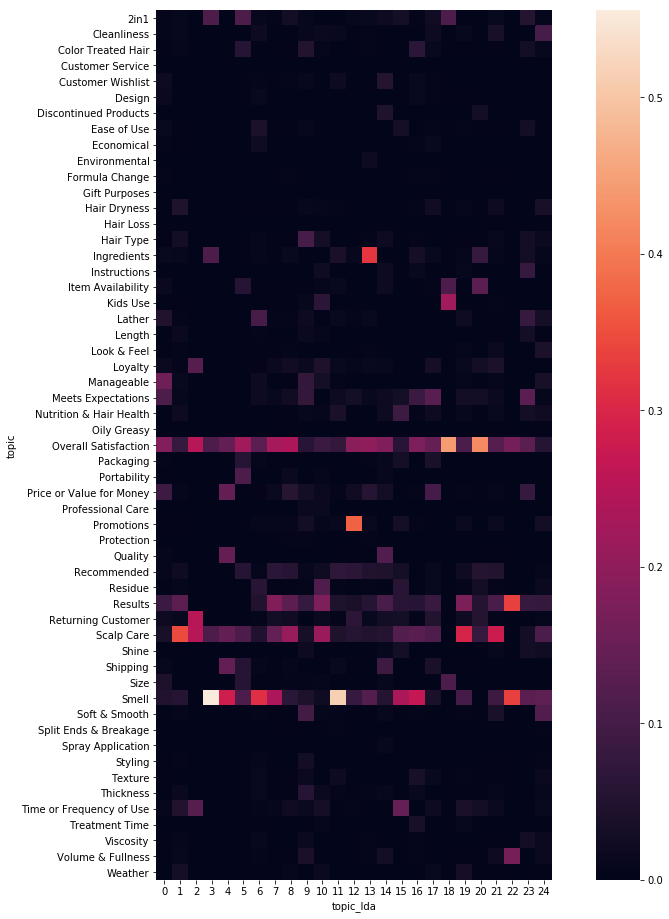

In [55]:
import seaborn as sns

plt.figure(figsize=(16, 16))
sns.heatmap(df_snippet4plotly.pivot("topic", "topic_lda", "values").fillna(0.), \
            annot=False, square=True)#, vmin=10, vmax=200)#

It seems that a few topics are still loaded with snippets

## What are the main drivers

In [81]:
df_document_drivers = df_document_topic.iloc[:,:-2].apply(lambda x: x>0.2).astype(int)

df_document_drivers.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_document_drivers = df_document_drivers.join(df_orig, how='left')

df_document_drivers.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,rating,product
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.0,Head And Shoulders Smooth & Silky Dandruff Sha...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.0,Head And Shoulders Green Apple Anti-Dandruff S...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,4.0,Dove Dermacare Scalp Anti-Dandruff Shampoo Inv...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4.0,"Head And Shoulders Dry Scalp Care, Almond Oil,..."


In [83]:
# convert to float
def float_(x):
    try:
        y=float(x)
    except:
        y=float('nan')
    return y

df_document_drivers['rating'] = df_document_drivers['rating'].apply(float_)

In [84]:
# put rating in the topic column
for col in df_document_drivers.columns[:-1]:
    df_document_drivers[col] = df_document_drivers[col].astype(float)
    df_document_drivers[col] = df_document_drivers.apply(lambda row: row[col]*row['rating'],axis=1)

In [85]:
# replace 0 with NaN
df_document_drivers.replace(0, np.NaN, inplace=True)

In [61]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [67]:
# get top words for each topic
no_top_words = 10

topWords = []
for topic_idx, topic in enumerate(lda.components_):
    topWords.append(" ".join([tf_feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [89]:
df_document_drivers['brand'] = df_document_drivers['product'].apply(lambda x: 'H&S' if 'head' in x.lower() else 'Dove' if 'dove' in x.lower() else 'other')

In [107]:
df_document_drivers_stats_HS = df_document_drivers.loc[df_document_drivers['brand']=='H&S'].count().reset_index().\
    merge(df_document_drivers.loc[df_document_drivers['brand']=='H&S'].mean().reset_index(),on='index').\
    rename(columns={'0_x':'count','0_y':'impact'}).iloc[:-1,:]
df_document_drivers_stats_HS['brand'] = 'H&S'
df_document_drivers_stats_HS['topWords'] = topWords
df_document_drivers_stats_HS['count'] = df_document_drivers_stats_HS['count']/df_document_drivers_stats_HS['count'].max()

df_document_drivers_stats_DV = df_document_drivers.loc[df_document_drivers['brand']=='Dove'].count().reset_index().\
    merge(df_document_drivers.loc[df_document_drivers['brand']=='Dove'].mean().reset_index(),on='index').\
    rename(columns={'0_x':'count','0_y':'impact'}).iloc[:-1,:]
df_document_drivers_stats_DV['brand'] = 'Dove'
df_document_drivers_stats_DV['topWords'] = topWords
df_document_drivers_stats_DV['count'] = df_document_drivers_stats_DV['count']/df_document_drivers_stats_DV['count'].max()

In [119]:
df_document_drivers_stats_HS.sort_values(by='impact', inplace=True)

In [120]:
df_document_drivers_stats_HS

,index,count,impact,brand,topWords
20,topic_20,0.001252,3.333333,H&S,glad patch combination neutrogena opportunity ...
13,topic_13,0.007092,3.647059,H&S,sulfate deal totally heavy ingredient contain ...
15,topic_15,0.002086,3.800000,H&S,daily mind finish return annoying pantene trus...
16,topic_16,0.007092,3.941176,H&S,color orange itching tea tree tingle hate stan...
6,topic_6,0.070088,4.053571,H&S,scent apple dove shampoo mint green old residu...
11,topic_11,0.006675,4.187500,H&S,sensitive strong quickly prefer turn break eff...
17,topic_17,0.018356,4.204545,H&S,original tgel severe 2in1 dark condition case ...
8,topic_8,0.029203,4.228571,H&S,stuff psoriasis save time dermatologist cheap ...
1,topic_1,0.570713,4.238304,H&S,scalp hair dry shampoo use dandruff help produ...
23,topic_23,0.002920,4.285714,H&S,believe low instruction pro beware intend frag...


In [114]:
df_document_drivers_stats_diff = \
    df_document_drivers_stats_HS[['index','impact','topWords']].merge(df_document_drivers_stats_DV[['index','impact']], on='index')
df_document_drivers_stats_diff['impact'] = df_document_drivers_stats_diff['impact_x']-df_document_drivers_stats_diff['impact_y']
df_document_drivers_stats_diff.sort_values(by='impact', inplace=True)

df_document_drivers_stats_diff.head()

,index,impact_x,topWords,impact_y,impact
16,topic_16,3.941176,color orange itching tea tree tingle hate stan...,5.0,-1.058824
17,topic_17,4.204545,original tgel severe 2in1 dark condition case ...,5.0,-0.795455
8,topic_8,4.228571,stuff psoriasis save time dermatologist cheap ...,5.0,-0.771429
10,topic_10,4.368421,remove daughter buildup dermatitis build sebor...,5.0,-0.631579
14,topic_14,4.400000,quality high body fast hope treat boyfriend re...,5.0,-0.600000


In [117]:
df_document_drivers_stats_diff

,index,impact_x,topWords,impact_y,impact
16,topic_16,3.941176,color orange itching tea tree tingle hate stan...,5.000000,-1.058824
17,topic_17,4.204545,original tgel severe 2in1 dark condition case ...,5.000000,-0.795455
8,topic_8,4.228571,stuff psoriasis save time dermatologist cheap ...,5.000000,-0.771429
10,topic_10,4.368421,remove daughter buildup dermatitis build sebor...,5.000000,-0.631579
14,topic_14,4.400000,quality high body fast hope treat boyfriend re...,5.000000,-0.600000
6,topic_6,4.053571,scent apple dove shampoo mint green old residu...,4.310345,-0.256773
24,topic_24,4.344180,hair shampoo feel review promotion collect pro...,4.465296,-0.121115
12,topic_12,4.380071,product free receive opinion review test smell...,4.461538,-0.081467
7,topic_7,4.331250,work smell great dandruff product buy bad clea...,4.391304,-0.060054
19,topic_19,4.310761,shampoo scalp dandruff head product shoulder r...,4.368932,-0.058171


In [108]:
df_document_drivers_stats = pd.concat([df_document_drivers_stats_HS, df_document_drivers_stats_DV])

df_document_drivers_stats.head()

,index,count,impact,brand,topWords
0,topic_0,0.186483,4.364653,H&S,bottle shampoo good price product great come s...
1,topic_1,0.570713,4.238304,H&S,scalp hair dry shampoo use dandruff help produ...
2,topic_2,0.001252,4.333333,H&S,preventative reorder source cease yr measure d...
3,topic_3,0.000417,5.000000,H&S,natural crazy drive pure rely gold wild intrig...
4,topic_4,0.001669,5.000000,H&S,dandrift stage manner oder bone smoothe proud ...


In [101]:
# df_document_drivers_stats = df_document_drivers.count().reset_index().\
#     merge(df_document_drivers.mean().reset_index(),on='index').\
#     rename(columns={'0_x':'count','0_y':'impact'}).iloc[:-1,:]

# df_document_drivers_stats['topWords'] = topWords

In [109]:
# Create a trace
trace = [
    go.Scatter(
    x    = df_document_drivers_stats['count'].loc[df_document_drivers_stats['brand']=='H&S'],
    y    = df_document_drivers_stats['impact'].loc[df_document_drivers_stats['brand']=='H&S'],
    text = df_document_drivers_stats['topWords'].loc[df_document_drivers_stats['brand']=='H&S'],
    name = 'H&S',
    mode = 'markers+text',
    marker = dict(
        size = 20,
        line = dict(
            width = 2,
            color = 'rgb(22, 96, 167)'),)
),
    go.Scatter(
    x    = df_document_drivers_stats['count'].loc[df_document_drivers_stats['brand']=='Dove'],
    y    = df_document_drivers_stats['impact'].loc[df_document_drivers_stats['brand']=='Dove'],
    text = df_document_drivers_stats['topWords'].loc[df_document_drivers_stats['brand']=='Dove'],
    name = 'Dove',
    mode = 'markers+text',
    marker = dict(
        size = 20,
        line = dict(
            width = 2,
            color = 'rgb(205, 12, 24)'),)
)]    

layout = dict(title = 'Topic Impact',
              xaxis = dict(zeroline = False, title='# of Comments'),
              yaxis = dict(zeroline = False, title='Avg. Rating')
             )

iplot(dict(data=trace, layout=layout))

In [76]:
plot(dict(data=[trace], layout=layout), filename='LDA.html')

'file:///workspace/voc_ratingsreviews/LDA.html'